In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from synthetic_datasets import BatchedInContextRecallDataset
from meta_optimizers import MetaSGD
from memory_module import inner_optimization_forward, TTT
from model_components import HyperparamModel, LearnableHyperparam
from evaluate import compute_recall_accuracies, correct_retrieval_counts_by_timestep, average_accuracy_by_offset
from linear_RNN import LinearAttentionMemory, MesaLayerMemory

In [2]:
key_dim=10
val_dim=10
context_size=5 # inner loss computation window
seq_len=30
batch_size=500
output_corr=0
inner_optimizer=MetaSGD()
#inner_optimizer_kwargs={ "beta": torch.tensor(0.9)}
#outer_optimizer_kwargs={"lr": 0.01}

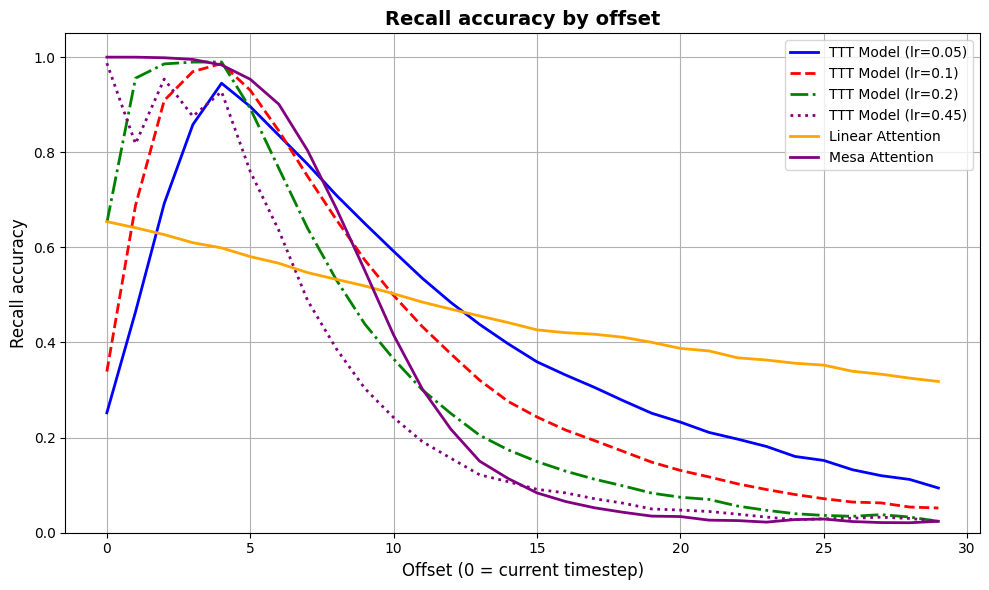

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = BatchedInContextRecallDataset(
    seq_len=seq_len,
    key_dim=key_dim,
    val_dim=val_dim,
    context_size=context_size,
    batch_size=batch_size,
)

learning_rates = [0.05, 0.1, 0.2, 0.45]
recall_acc = {}
retrieval_counts = {}

for lr in learning_rates:

    _, predictions = inner_optimization_forward(
        memory_module=TTT(key_dim,val_dim,1, 0.0).to(device),
        dataset=dataset.to(device),
        inner_opt=inner_optimizer,
        lr_head=lr,
        loss_weight_head=torch.ones(context_size).to(device),
        eval_mode=True
    )

    accuracies = compute_recall_accuracies(predictions,dataset.targets)
    accuracy_by_offset, count = average_accuracy_by_offset(accuracies)
    retrieval_count = correct_retrieval_counts_by_timestep(accuracies)

    # Store results
    recall_acc[lr] = accuracy_by_offset.to("cpu")
    retrieval_counts[lr]=retrieval_count.to("cpu")

# linear attention
state = LinearAttentionMemory.init_state(batch_size, val_dim, key_dim).to(device)
predictions = []

# mesa layer attention
gamma = torch.tensor(.8)
mesa_memory = MesaLayerMemory(key_dim, val_dim)
R_matrix, S_matrix, phi_matrix = mesa_memory.init_state(batch_size)
mesa_predictions = []

keys = dataset.inputs            # (B, seq_len, key_dim)
values = dataset.targets         # (B, seq_len, val_dim)

for t in range(seq_len):
    key_t = keys[:,t]         # (B, key_dim)
    value_t = values[:,t]      # (B, val_dim)

    #update state
    state = LinearAttentionMemory.update(state, key_t, value_t)

    prefix_keys = keys[:,:t+1]          # (B, t+1, key_dim)
    preds_t = LinearAttentionMemory.forward(state, prefix_keys) # (B, t+1, val_dim)
    predictions.append(preds_t)

    # mesa layer
    R_matrix, S_matrix, phi_matrix = mesa_memory.update(R_matrix, S_matrix, phi_matrix, key_t, value_t, gamma)

    mesa_preds_t = mesa_memory.forward(phi_matrix, prefix_keys)
    mesa_predictions.append(mesa_preds_t)

lin_attn_accuracy_history = compute_recall_accuracies(predictions, values)
lin_attn_accuracy_by_offset, _ = average_accuracy_by_offset(lin_attn_accuracy_history)
lin_attn_accuracy_by_offset= lin_attn_accuracy_by_offset.to("cpu")

mesa_acc_history = compute_recall_accuracies(mesa_predictions,values)
mesa_acc_by_offset, _ = average_accuracy_by_offset(mesa_acc_history)
mesa_acc_by_offset = mesa_acc_by_offset.to("cpu")

plt.figure(figsize=(10, 6))

# Define colors and line styles for each learning rate
colors = ['blue', 'red', 'green', 'purple']
line_styles = ['-', '--', '-.', ':']

plot_configs = []
for i, lr in enumerate(learning_rates):
    plot_configs.append({
        "label": f'TTT Model (lr={lr})',
        "values": recall_acc[lr],
        "color": colors[i],
        "linestyle": line_styles[i]
    })

plot_configs.extend([
    {
        "label": "Linear Attention",
        "values": lin_attn_accuracy_by_offset,
        "color": "orange",
        "linestyle": "-",
    },
    {
        "label": "Mesa Attention",
        "values": mesa_acc_by_offset,
        "color": "purple",
        "linestyle": "-",
    },
])

for config in plot_configs:
    offsets = np.arange(len(config["values"]))
    plt.plot(
        offsets,
        config["values"],
        color=config["color"],
        linestyle=config["linestyle"],
        linewidth=2,
        label=config["label"],
    )

# Plot average accuracy by offset
plt.xlabel("Offset (0 = current timestep)", fontsize=12)
plt.ylabel("Recall accuracy", fontsize=12)
plt.title("Recall accuracy by offset", fontsize=14, fontweight='bold')
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


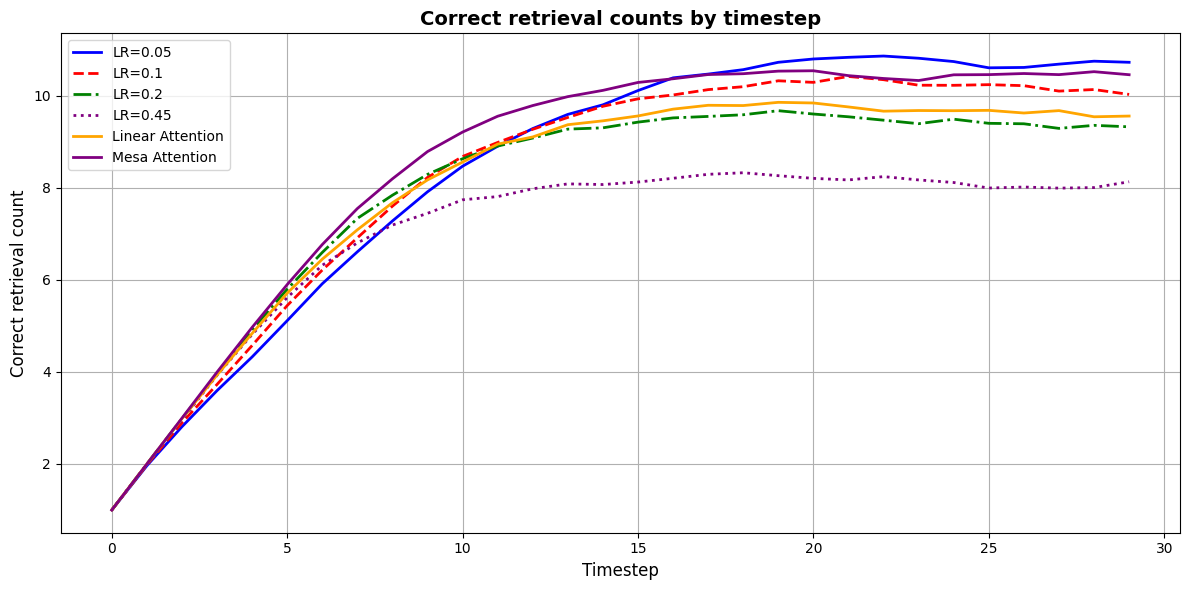

In [4]:
# Plot retrieval counts by timestep
plt.figure(figsize=(12, 6))

# Define colors and line styles for each learning rate
colors = ['blue', 'red', 'green', 'purple']
line_styles = ['-', '--', '-.', ':']

lin_attn_retrieval_count = correct_retrieval_counts_by_timestep(lin_attn_accuracy_history).to("cpu")
mesa_retrieval_count = correct_retrieval_counts_by_timestep(mesa_acc_history).to("cpu")

retrieval_plot_configs = []
for i, lr in enumerate(learning_rates):
    retrieval_plot_configs.append({
        "label": f'LR={lr}',
        "values": retrieval_counts[lr],
        "color": colors[i],
        "linestyle": line_styles[i]
    })

retrieval_plot_configs.extend([
    {
        "label": "Linear Attention",
        "values": lin_attn_retrieval_count,
        "color": "orange",
        "linestyle": "-",
    },
    {
        "label": "Mesa Attention",
        "values": mesa_retrieval_count,
        "color": "purple",
        "linestyle": "-",
    },
])

for config in retrieval_plot_configs:
    timesteps = np.arange(len(config["values"]))
    plt.plot(
        timesteps,
        config["values"],
        color=config["color"],
        linestyle=config["linestyle"],
        linewidth=2,
        label=config["label"],
    )

plt.xlabel("Timestep", fontsize=12)
plt.ylabel("Correct retrieval count", fontsize=12)
plt.title("Correct retrieval counts by timestep", fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
